<a href="https://colab.research.google.com/github/alex283h/YOLOv3_test_task/blob/master/task_1_230622_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Устанавливаем пакет для загрузки рыночных данных:

# New Section

In [2]:
!pip3 install yfinance 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.8 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Также установим пакет для расчета различных индикаторов рынка:

In [3]:
!pip3 install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=b2d765eca37e539bba938f48ef8b02b15beb1ec85d3518cd2864a8d79d955e02
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta


Все индикаторы, которые могут быть рассчитаны с помощью данного пакета можно посмотреть по ссылке:

https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#volume-indicators

Например, в статье на которую мы ориентируемся индикатор ATR был реализован собственноручно. Насколько правильно неизвестно, кода-то нет. Здесь же все выверено и есть много дополнительных полезных "штук" приработе с которовками.
Поэтому в качестве первого нашего улучшения будем пользоватсья данным пакетом.
Удобьно и быстро.

Загрузим все необходимые библиотеки для последующей работы:

In [4]:
import pandas as pd # для работы с дата-фреймами
import numpy as np # для работы с массивами и матрицами
from matplotlib import pyplot as plt # для работы с графиками
import datetime # для работы с временем и датами
import yfinance as yf # для загрузки котировок
import seaborn as sns # для работы с графиками
from sklearn.cluster import KMeans # для кластеризации
import ta # индикаторы технического анализа
from sklearn.preprocessing import StandardScaler,MinMaxScaler # масштабирование признаков
from yellowbrick.cluster import KElbowVisualizer # удобная визуализация кластерной модели с различным числом кластеров
import plotly.graph_objects as go # визуализация рыночных показателей и индикаторов
from sklearn.decomposition import PCA # наиболее популярный метод сокращения размерности для визуализации
from sklearn.manifold import TSNE # более продвинутый метод сокращения размерности для визуализации

Обределим даты начала и окончания загрузки показателя SPX (еще S&P 500 или GSPC; именно он выбран в статье за основу).
Загрузим днные за примерно 32 года по дням:

In [5]:
end_time = datetime.date.today()
start_time = end_time - datetime.timedelta(11850)

In [6]:
SPX = yf.download('^GSPC',start = start_time, end = end_time)
SPX

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
1990-01-15   339.929993   339.940002   336.570007   337.000000   337.000000   
1990-01-16   337.000000   340.750000   333.369995   340.750000   340.750000   
1990-01-17   340.769989   342.010010   336.260010   337.399994   337.399994   
1990-01-18   337.399994   338.380005   333.980011   338.190002   338.190002   
1990-01-19   338.190002   340.480011   338.190002   339.149994   339.149994   
...                 ...          ...          ...          ...          ...   
2022-06-16  3728.179932  3728.179932  3639.770020  3666.770020  3666.770020   
2022-06-17  3665.899902  3707.709961  3636.870117  3674.840088  3674.840088   
2022-06-21  3715.310059  3779.649902  3715.310059  3764.790039  3764.790039   
2022-06-22  3733.889893  3801.790039  3717.689941  3759.889893  3759.889893   
2022-06-23  3774.709961  3802.580078  3743.520020  3795.729980  3795.729980   

                Volume  
Date                    
1990-01-15   140590000  
1990-01-16   186070000  
1990-01-17   170470000  
1990-01-18   178590000  
1990-01-19   185590000  
...                ...  
2022-06-16  4511200000  
2022-06-17  6954110000  
2022-06-21  4124600000  
2022-06-22  4342270000  
2022-06-23  4078100000  

[8174 rows x 6 columns]

Данные загружены, все хорошо. Теперь дополнительно, как и авторы статьи загрузим вспомогательный индикатор-показатель рынка VIX (за тоже время):

In [7]:
VIX = yf.download('^VIX',start = start_time, end = end_time).Close
VIX

[*********************100%***********************]  1 of 1 completed


Date
1990-01-15    26.340000
1990-01-16    24.180000
1990-01-17    24.160000
1990-01-18    24.340000
1990-01-19    22.500000
                ...    
2022-06-17    31.129999
2022-06-21    30.190001
2022-06-22    28.950001
2022-06-23    29.049999
2022-06-24    28.680000
Name: Close, Length: 8175, dtype: float64

Визуализируем этот показатель:

In [8]:
fig = go.Figure(data=go.Scatter(x=VIX.index,y=VIX, mode='lines'))
fig.update_layout(autosize=False,width=800,height=500)
fig.show()

VIX — это индикатор волатильности американской экономики. Он показывает, будет ли индекс S&P 500 волатилен в будущем. Когда VIX растет, это значит, что инвесторы ожидают сильных колебаний фондового рынка и даже наступления кризиса: именно к таким последствиям может привести рост волатильности S&P 500. Хорошо то, что данный показатель не имеет явно выраженного тренда и является стационарным относительно некоего среднего значения. То есть его диапазон возможных значений конечен и псевдо-фиксирован.

Далее вычислим показатель ATR за период равный 14 дням. Как и у авторов статьи:

In [9]:
ATR = ta.volatility.AverageTrueRange(SPX.High,SPX.Low,SPX.Close,window = 14, fillna = True).average_true_range()/SPX.Close
ATR

Date
1990-01-15    0.000000
1990-01-16    0.000000
1990-01-17    0.000000
1990-01-18    0.000000
1990-01-19    0.000000
                ...   
2022-06-16    0.027753
2022-06-17    0.027091
2022-06-21    0.026544
2022-06-22    0.026278
2022-06-23    0.025282
Length: 8174, dtype: float64

Визуализируем показатель:

In [10]:
fig = go.Figure(data=go.Scatter(x=ATR.index,y=ATR, mode='lines'))
fig.update_layout(autosize=False,width=800,height=500)
fig.show()

В целом визуально (возможно и по статистикам) данный показатель похож на предыдущий.

Вычислим (как и у авторов статьи) следующий показатель - Daily retutns:

In [11]:
DR = ta.others.DailyReturnIndicator(SPX.Close, fillna = True).daily_return()
DR[0] = DR.mean() # здесь важный момент! чтобы самое первое значение не было слишком большим и отличающимся от остальных, заменим его на среднее (специфика вычислений показателя)
DR

Date
1990-01-15    0.026797
1990-01-16    1.112760
1990-01-17   -0.983127
1990-01-18    0.234146
1990-01-19    0.283862
                ...   
2022-06-16   -3.251195
2022-06-17    0.220087
2022-06-21    2.447724
2022-06-22   -0.130157
2022-06-23    0.953222
Name: d_ret, Length: 8174, dtype: float64

Визуализируем показатель:

In [12]:
fig = go.Figure(data=go.Scatter(x=DR.index,y=DR, mode='lines'))
fig.update_layout(autosize=False,width=800,height=500)
fig.show()

Выглядит отлично. Как минимум стационарно по среднему (среднее около 0). И нестационарно по дисперсии. Для кластеризации что надо!

Далее авторы также применяют показатель Return Volume. Его нет в пакетной врсии, поэтому просто воспользуемся готовым авторским кодом:

In [13]:
RV = SPX.Volume/SPX.Volume.rolling(40).mean()
RV = RV.fillna(0)
RV

Date
1990-01-15    0.000000
1990-01-16    0.000000
1990-01-17    0.000000
1990-01-18    0.000000
1990-01-19    0.000000
                ...   
2022-06-16    1.109814
2022-06-17    1.678586
2022-06-21    0.994434
2022-06-22    1.045142
2022-06-23    0.979686
Name: Volume, Length: 8174, dtype: float64

И визуализация:

In [14]:
fig = go.Figure(data=go.Scatter(x=RV.index,y=RV, mode='lines'))
fig.update_layout(autosize=False,width=800,height=500)
fig.show()

Вполне годится. Стационарность относительно среднего есть.

На этих 4 показателях авторы статьи останавливаются и проделывают кластеризацию. Мы же в качестве второго улучшения добавим на 1 показатель больше. Метод кластеризации KMeans может неплохо справляться где-то с 8-10 показателями (индикаторами). Далее начинается проблема "прколятия размерности".

Выберем в качестве такого показателя Stochastic RSI. Важен не столько смысл данного показателя, как тот факт, что показатель стауионарен относительно среднего и ограничен в диапазоне значений от 0 до 1.

Если Вы работаете с рынками и знаете какие показатели лучше применить для данной задачи по смыслу (кластеризация рыночных моментов) и эти показатели стационарны относительно среднего - можно смело эксперементировать!

В рамках кластеризации плохи те показатели, что имеют тренды как и сам рынок. Такие данные будут очень плохо кластеризуемы.


In [15]:
RSI = ta.momentum.StochRSIIndicator(SPX.Close, fillna = True).stochrsi()
RSI

Date
1990-01-15    0.000000
1990-01-16    0.000000
1990-01-17    0.000000
1990-01-18    0.000000
1990-01-19    0.000000
                ...   
2022-06-16    0.000000
2022-06-17    0.026635
2022-06-21    0.312293
2022-06-22    0.302897
2022-06-23    0.438192
Name: stochrsi, Length: 8174, dtype: float64

Визуализация:

In [16]:
fig = go.Figure(data=go.Scatter(x=RSI.index,y=RSI, mode='lines'))
fig.update_layout(autosize=False,width=800,height=500)
fig.show()

Отлично! Теперь соберем все вычисленные показатели в единый дата-фрейм X для последующей кластеризации:

In [17]:
X = pd.concat([DR,ATR,VIX,RV,RSI], axis=1)
X.columns = ['DR','ATR','VIX','RV','RSI']
X

DR       ATR        VIX        RV       RSI
Date                                                         
1990-01-15  0.026797  0.000000  26.340000  0.000000  0.000000
1990-01-16  1.112760  0.000000  24.180000  0.000000  0.000000
1990-01-17 -0.983127  0.000000  24.160000  0.000000  0.000000
1990-01-18  0.234146  0.000000  24.340000  0.000000  0.000000
1990-01-19  0.283862  0.000000  22.500000  0.000000  0.000000
...              ...       ...        ...       ...       ...
2022-06-17  0.220087  0.027091  31.129999  1.678586  0.026635
2022-06-21  2.447724  0.026544  30.190001  0.994434  0.312293
2022-06-22 -0.130157  0.026278  28.950001  1.045142  0.302897
2022-06-23  0.953222  0.025282  29.049999  0.979686  0.438192
2022-06-24       NaN       NaN  28.680000       NaN       NaN

[8175 rows x 5 columns]

Все хорошо. Но бывают ситуации, когда данные основного показателя (в нашем случае SPX) приходят раньше, чем VIX и мы можем получить пропущенные значения в последней строке. Сейчас все хорошо. Но для корректировки таких случаев добавим следующий код:

In [18]:
X = X.dropna()
X

DR       ATR        VIX        RV       RSI
Date                                                         
1990-01-15  0.026797  0.000000  26.340000  0.000000  0.000000
1990-01-16  1.112760  0.000000  24.180000  0.000000  0.000000
1990-01-17 -0.983127  0.000000  24.160000  0.000000  0.000000
1990-01-18  0.234146  0.000000  24.340000  0.000000  0.000000
1990-01-19  0.283862  0.000000  22.500000  0.000000  0.000000
...              ...       ...        ...       ...       ...
2022-06-16 -3.251195  0.027753  32.950001  1.109814  0.000000
2022-06-17  0.220087  0.027091  31.129999  1.678586  0.026635
2022-06-21  2.447724  0.026544  30.190001  0.994434  0.312293
2022-06-22 -0.130157  0.026278  28.950001  1.045142  0.302897
2022-06-23  0.953222  0.025282  29.049999  0.979686  0.438192

[8174 rows x 5 columns]

Следующим важным улучшением (чего нет у авторов!) является масштабирование всех признаков. Метод K-Means чувствителен к диапазону индикаторов, так как основывается на вычислениях расстояний между векторами. Все индикаторы должны быть приведены к единому диапазону, иначе какой-то один будет "доминантным", а остальные могут не оказывать почти никакого влияния. Работа с ненормированными (немасштабированными) данными частая ошибка при кластеризации! Вот подробные объяснения почему: https://medium.com/analytics-vidhya/why-is-scaling-required-in-knn-and-k-means-8129e4d88ed7

Произведем масштабирование всех прихнаков в интервале 0-1:

In [19]:
t_scaler = MinMaxScaler().fit(X)
t_X = pd.DataFrame(t_scaler.transform(X))
t_X.columns = X.columns
t_X

DR       ATR       VIX        RV       RSI
0     0.509710  0.000000  0.233855  0.000000  0.000000
1     0.555795  0.000000  0.204487  0.000000  0.000000
2     0.466851  0.000000  0.204215  0.000000  0.000000
3     0.518509  0.000000  0.206662  0.000000  0.000000
4     0.520619  0.000000  0.181645  0.000000  0.000000
...        ...       ...       ...       ...       ...
8169  0.370600  0.391477  0.323725  0.522897  0.000000
8170  0.517913  0.382139  0.298980  0.790877  0.026635
8171  0.612448  0.374414  0.286200  0.468534  0.312293
8172  0.503049  0.370660  0.269341  0.492426  0.302897
8173  0.549025  0.356611  0.270700  0.461586  0.438192

[8174 rows x 5 columns]

Теперь все хорошо. Но перед тем, как начинать какую-либо кластеризацию, всегда стоит посмотреть на распределение показателей в 2D проекции. Для этого существует множество методов: PCA, tSNE, UMAP... Мы воспользуемся наиболее простым и популярным PCA и визуализируем первые 2 компоненты в 2D плоскости. Если мы увидем какие-то отдельные группы точек - то хорошо. Если нет - то вообще кластеризация, как таковая, и её смысл может быть весьма спорным... Сделаем это:

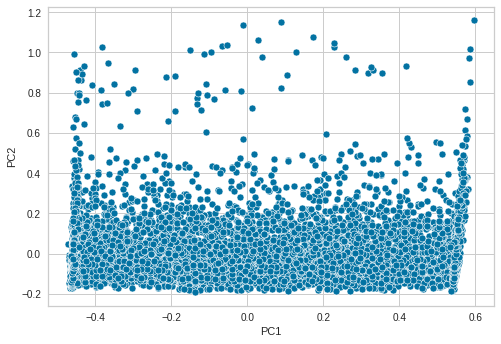

In [20]:
pca = PCA(n_components = 2)
pca_data = pd.DataFrame(pca.fit_transform(t_X),columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=pca_data)
plt.show()

Честно говоря, мало обещающий график. Каких-либо групп точек мы не видем. Как разделить или кластеризовать такие данные? Однозначный способ не прослеживается.
..
Бывает так, что PCA в двухмерном пространстве действительно не отображет сложные многомерные кластеры. Попробуем применить более продвинутый метод - tSNE. Он также основан на вычислении расстояний, как и метод кластеризации K-Means. Но при этом учитывает многомерные статистики. Метод требует куда как больше времени на вычисления (чем больше значение n_iter - тем дольше и точнее будут кластеры; можно экспериментировать!).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 8174 samples in 0.022s...
[t-SNE] Computed neighbors for 8174 samples in 0.175s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8174
[t-SNE] Computed conditional probabilities for sample 2000 / 8174
[t-SNE] Computed conditional probabilities for sample 3000 / 8174
[t-SNE] Computed conditional probabilities for sample 4000 / 8174
[t-SNE] Computed conditional probabilities for sample 5000 / 8174
[t-SNE] Computed conditional probabilities for sample 6000 / 8174
[t-SNE] Computed conditional probabilities for sample 7000 / 8174
[t-SNE] Computed conditional probabilities for sample 8000 / 8174
[t-SNE] Computed conditional probabilities for sample 8174 / 8174
[t-SNE] Mean sigma: 0.021584
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.365128
[t-SNE] KL divergence after 1500 iterations: 1.344777


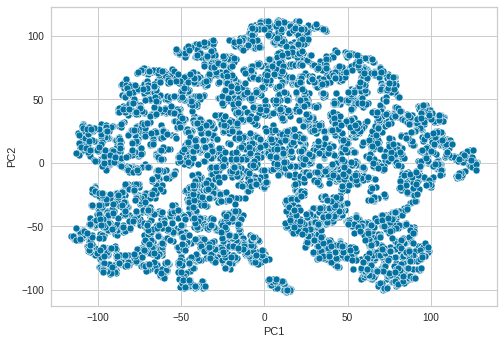

In [21]:
tsne = TSNE(n_components=2, verbose=1, random_state=0, perplexity = 15, n_iter = 1500)
tsne_data = pd.DataFrame(tsne.fit_transform(t_X),columns=['PC1','PC2']) 
sns.scatterplot(x="PC1",y="PC2",data=tsne_data)
plt.show()

Какие-то группы точек уже можно различать. Но и тут нет красивой однозначности. Поэтому, попробуем сделать кластеризацию не только исходных данных с 5-ю показателями, но и кластеризацию данных, полученных после метода tSNE. ВОзможно будет лучше.

В следующих шагах мы выполним K-Means кластеризацию исходных данных и найдем "оптимальное" число кластеров. Авторы применяют в статье лишь один метод - метод "локтя" или Elbow метод. Но есть и другие метрики для првоерки оптимального числа кластеров. Наиболее популярные три:

- Elbow;
- Calinski Harabasz;
- Silhouette.

Вот и посмотрим их все. Сколько кластеров оптимально получится используя ту или иную метрику. Это будет нашим еще одним улучшением.

**1. Кластеризация по исходным данным.**

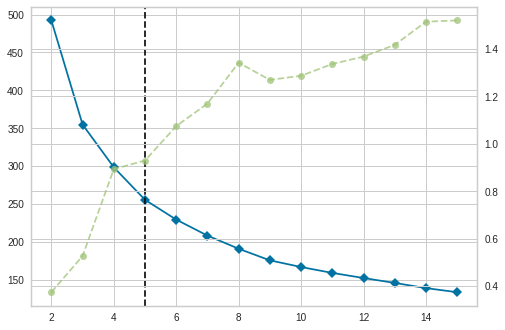

In [22]:
# Elbow метод для K-Means
model = KMeans()
# k - диапазон возможных кластеров
visualizer = KElbowVisualizer(model, k=(2,16), timings= True)
visualizer.fit(t_X)
# визуализация
plt.show()
visualizer.show()

Вот с помощью данного метода получилось 5 кластеров - лучший выбор.
Визуализируем эти кластеры с помощью 2D проекции на базе tSNE (он получше все сделал, как мы видели ранее):

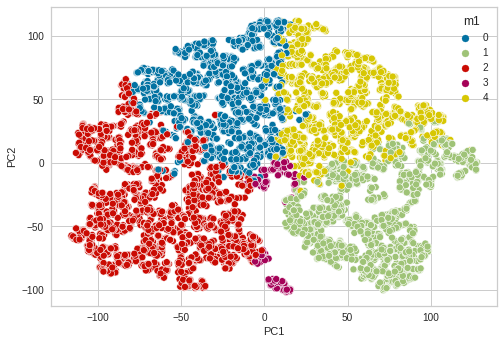

In [23]:
m1 = KMeans(n_clusters=5).fit(t_X)
tsne_data['m1'] = pd.Categorical(m1.labels_) # добавим метки кластеров в данные tsne
sns.scatterplot(x="PC1",y="PC2",hue="m1",data=tsne_data)
plt.show()

Аак-то вот так распределились облака точек. Проверим другие два метода:

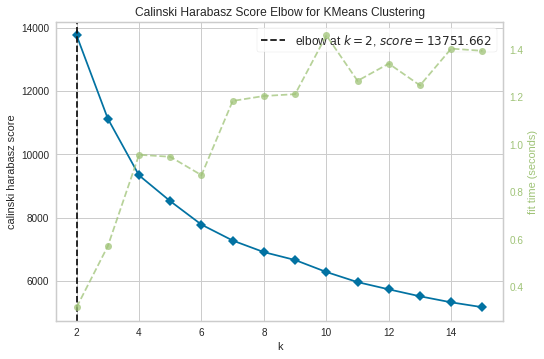

In [24]:
# Calinski Harabasz метод
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,16),metric='calinski_harabasz', timings= True)
visualizer.fit(t_X)
visualizer.show()

Здесь метод "посчитал", что 2 кластера - лучший выбор.

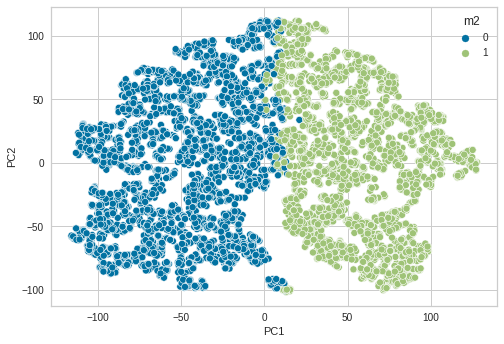

In [25]:
m2 = KMeans(n_clusters=2).fit(t_X)
tsne_data['m2'] = pd.Categorical(m2.labels_) # добавим метки кластеров в данные tsne
sns.scatterplot(x="PC1",y="PC2",hue="m2",data=tsne_data)
plt.show()

Тут разделение пошло по границе наименьшего "соприкосновения" 2 облаков точек. Хорошо это или нет, сказать пока сложно. Взглянем на последний метод:

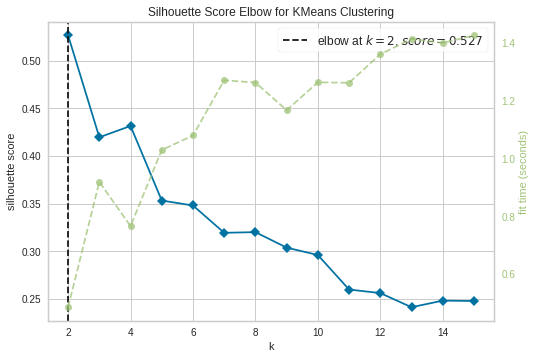

In [26]:
# Silhouette
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,16),metric='silhouette', timings= True)
visualizer.fit(t_X)
visualizer.show()

И этот метод "рекомендует" выбрать только 2 кластера.

У авторов статьи число кластеров получилось больше двух. Но они руководствовались лишь одним методом. В нашем же случае из 3-х проверенных методов 2 "говорят" в пользу выбора только 2 кластеров. Нам следует так и сделать... это более надежный подход.

Теперь в заключение следует вывести исходный график SPX (данные по Close) с подсветкой двух кластеров:

In [27]:
fig = go.Figure(data=go.Scatter(x=SPX.index,y=SPX.Close, 
                                mode="markers",
                                marker_color=m2.labels_))
fig.update_layout(autosize=False,width=800,height=500)
fig.show()

Вот такой график получился. Да, похоже на то что сильным медвежьим трендам более соответствуют последовательности "синих" кластеров, а "желтые" говорят о равномерном движении.

Если же "подсветить" кластеры, что были найдены первым методом (их 5), то получим вот что:

In [28]:
fig = go.Figure(data=go.Scatter(x=SPX.index,y=SPX.Close, 
                                mode="markers",
                                marker_color=m1.labels_))
fig.update_layout(autosize=False,width=800,height=500)
fig.show()

Здесь явно прослеживаются "ораньжевые" кластеры.

Все это можно интерпретировать как нам угодно, но нужно не уйти в сторону и не "выдавать желаемое за действительное".

**2. Кластеризация по данным tSNE.**

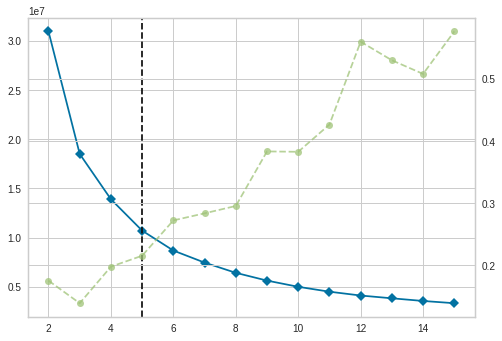

In [29]:
# Elbow метод для K-Means
model = KMeans()
# k - диапазон возможных кластеров
visualizer = KElbowVisualizer(model, k=(2,16), timings= True)
visualizer.fit(tsne_data.iloc[:,:2])
# визуализация
plt.show()
visualizer.show()

Все теже 5 кластеров! Визуализация:

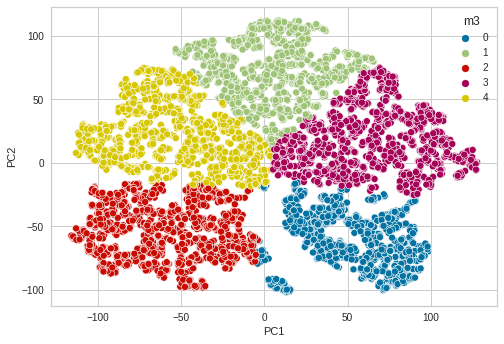

In [30]:
m3 = KMeans(n_clusters=5).fit(tsne_data.iloc[:,:2])
tsne_data['m3'] = pd.Categorical(m3.labels_) # добавим метки кластеров в данные tsne
sns.scatterplot(x="PC1",y="PC2",hue="m3",data=tsne_data)
plt.show()

Сейчас красивее и четче видны "облака" точек.

Второй метод:

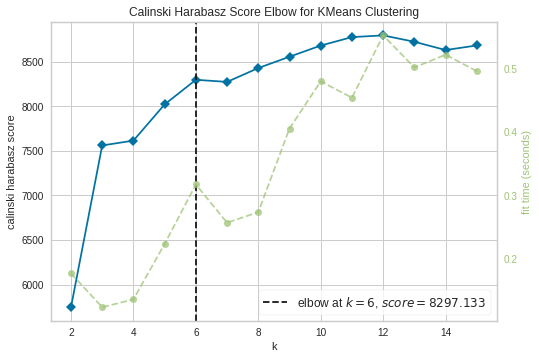

In [31]:
# Calinski Harabasz метод
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,16),metric='calinski_harabasz', timings= True)
visualizer.fit(tsne_data.iloc[:,:2])
visualizer.show()

А тут метод "предпочел" выбрать 6 кластеров!

Визуализируем:

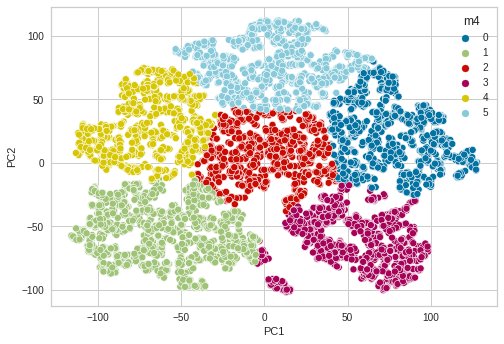

In [32]:
m4 = KMeans(n_clusters=6).fit(tsne_data.iloc[:,:2])
tsne_data['m4'] = pd.Categorical(m4.labels_) # добавим метки кластеров в данные tsne
sns.scatterplot(x="PC1",y="PC2",hue="m4",data=tsne_data)
plt.show()

Выглядит вполне себе неплохо. И првоерим последний метод:

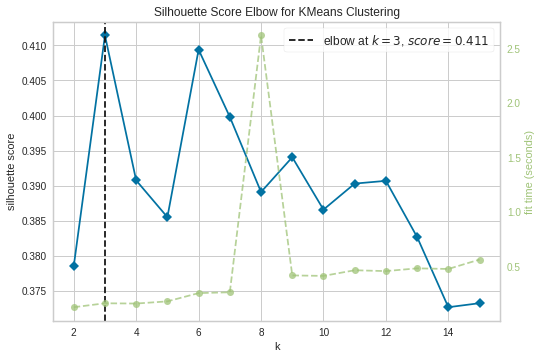

In [33]:
# Silhouette
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,16),metric='silhouette', timings= True)
visualizer.fit(tsne_data.iloc[:,:2])
visualizer.show()

А этот метод предлагает выбрать только 3 группы! Визуализируем их:

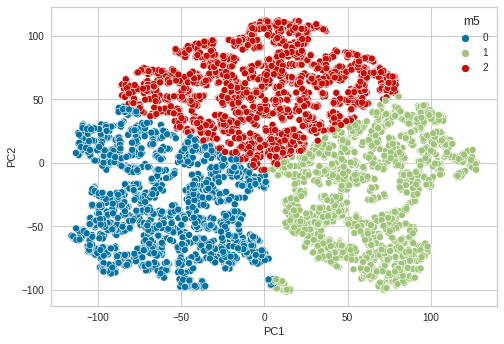

In [34]:
m5 = KMeans(n_clusters=3).fit(tsne_data.iloc[:,:2])
tsne_data['m5'] = pd.Categorical(m5.labels_) # добавим метки кластеров в данные tsne
sns.scatterplot(x="PC1",y="PC2",hue="m5",data=tsne_data)
plt.show()

Тут выбрать сложно, поэтому посмотрим на реальный график цены SPX со всеми обозначенными кластерами кластерами для каждого из 3-х методов поиска оптимального числа кластеров:

In [35]:
fig = go.Figure(data=go.Scatter(x=SPX.index,y=SPX.Close, 
                                mode="markers",
                                marker_color=m3.labels_))
fig.update_layout(autosize=False,width=800,height=500)
fig.show()

In [36]:
fig = go.Figure(data=go.Scatter(x=SPX.index,y=SPX.Close, 
                                mode="markers",
                                marker_color=m4.labels_))
fig.update_layout(autosize=False,width=800,height=500)
fig.show()

In [37]:
fig = go.Figure(data=go.Scatter(x=SPX.index,y=SPX.Close, 
                                mode="markers",
                                marker_color=m5.labels_))
fig.update_layout(autosize=False,width=800,height=500)
fig.show()

Самый первый график интереснее. Нисходящие тенденции более оранжево-красные, а восходящие розово-синии.

**Рекомендации**

Не смотря на то, что было проверено несколько методов поиска оптимального числа кластеров по 5 показателям и по их проекции в 2D плоскость методом tSNE существенных результатов, которые бы были видны визуально не видно. Не вижно это явно и в статье авторов (у них признаки не нормируются). Скорее можно говорить о некоторых незначительных закономерностях которые "подсвечиваются" метками кластеров.

Как альтернативу работе, можно попробовать проводить кластеризацию рыночных паттернов, то есть последовательностей рыночных цен, например, взяв их понедельно. Сюда также можно добавить технические индикаторы для "большей" информативности.

Но и в том и в другом можно построить модель классификации будущего значения рынка (то есть модель, которая бы прогнозировала кластер к которому будет принадлежать будущее значение или паттерн).



In [60]:
# конвертация в html
%%shell
jupyter nbconvert --to html //task_1_230622_v2.ipynb

[NbConvertApp] Converting notebook //task_1_230622_v2.ipynb to html
[NbConvertApp] Writing 5574113 bytes to //task_1_230622_v2.html


# New Section

# New Section